In [22]:


import ReactorSpectra
from CrossSection import dSigdEr 
from CrossSection import dSigIBD
from NESTYields import NESTCharge
from NEST_ionization import NESTChargeLow
from NEST_ionization import NESTChargeHi
from MathLib import TrapIntegral
import Detector 
import numpy as np
from matplotlib import pyplot as plt
from InelasticAnalysisLib import RateVsEnergy

import pandas as pd


plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams.update({'font.size': 18})
plt.rcParams["font.weight"] = 'light'
plt.rcParams["axes.labelweight"] = 'light'
plt.rcParams["font.family"] = ['Times New Roman']

In [23]:
db_reactors = pd.read_csv('Copy of Ultralytics Worldwide Reactor Database - Sheet1.csv')
db_reactors.head()

,Country,Sitename,Location,Status,Gross (MWe),Capacity (MWt),Mean LF (%),2015 LF (%),lat (-90 to 90),lng (-180 to 180),alt (m)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARMENIA,ARMENIAN-1,Armavir,Permanent Shutdown,408.0,1375.0,0.0,0.0,40.180844,44.148908,925.3
2,ARMENIA,ARMENIAN-2,Armavir,Operational,408.0,1375.0,65.2,78.3,40.180844,44.148908,925.3
3,ARGENTINA,ATUCHA-1,"Zárate Partido, Buenos Aires Province",Operational,357.0,1179.0,71.5,88.4,-33.963330,-59.186390,27.7
4,ARGENTINA,EMBALSE,"Calamuchita Department, Cordoba",Operational,648.0,2015.0,78.7,12.2,-32.232000,-64.443000,633.5


In [24]:
op_mask = db_reactors['Status'] == 'Operational'

In [25]:
# Coordinates of LNGS
lngs_lat = 42.454 # degrees north
lngs_lon = 13.576 # degrees east

# Coordinates of Homestake
home_lat = 44. + 21./60. # degrees north
home_lon = -(103. + 45./60.) # degrees west

sno_lat = 46.4719 # degrees north
sno_lon = -81.1868 # degrees west

# Radius of the earth
R = 6371.0 # km

In [26]:
# Write function to accept two locations in degrees on a sphere of radius R, then 
# calculate their true 3D distance from each other. We take the convention given 
# by the reactors sheet: latitude is measured from -90 to 90, and longitude is
# measured from -180 to 180
def distance_calc( R, lat1, lon1, lat2, lon2 ):
    if lat1 < 0.:
        lat1 = -1.*lat1 + 90.
    else:
        lat1 = 90. - lat1
    if lat2 < 0.:
        lat2 = -1.*lat2 + 90.
    else:
        lat2 = 90. - lat2
    if lon1 < 0.:
        lon1 = (-1.*lon1) + 180.
    if lon2 < 0.:
        lon2 = (-1.*lon2) + 180.
        
    x1 = R * np.sin(lat1*np.pi/180.) * np.cos(lon1*np.pi/180.)
    y1 = R * np.sin(lat1*np.pi/180.) * np.sin(lon1*np.pi/180.)
    z1 = R * np.cos(lat1*np.pi/180.)
    
    x2 = R * np.sin(lat2*np.pi/180.) * np.cos(lon2*np.pi/180.)
    y2 = R * np.sin(lat2*np.pi/180.) * np.sin(lon2*np.pi/180.)
    z2 = R * np.cos(lat2*np.pi/180.)
    
    #print('X1: {} Y1: {} Z1: {}'.format(x1,y1,z1))
    #print('X2: {} Y2: {} Z2: {}'.format(x2,y2,z2))
    #print('Dist: {}'.format(np.sqrt( (x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2 )))
    
    return np.sqrt( (x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2 )


In [27]:
# Add a column to the dataframe giving the distance of each reactor to each lab.

db_reactors['Dist to LNGS'] = np.zeros(len(db_reactors['lat (-90 to 90)']))

for index,row in db_reactors.iterrows():
    db_reactors['Dist to LNGS'].loc[index] = distance_calc(R,lngs_lat,lngs_lon,row['lat (-90 to 90)'],row['lng (-180 to 180)'])

db_reactors.head()


,Country,Sitename,Location,Status,Gross (MWe),Capacity (MWt),Mean LF (%),2015 LF (%),lat (-90 to 90),lng (-180 to 180),alt (m),Dist to LNGS
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARMENIA,ARMENIAN-1,Armavir,Permanent Shutdown,408.0,1375.0,0.0,0.0,40.180844,44.148908,925.3,2534.847784
2,ARMENIA,ARMENIAN-2,Armavir,Operational,408.0,1375.0,65.2,78.3,40.180844,44.148908,925.3,2534.847784
3,ARGENTINA,ATUCHA-1,"Zárate Partido, Buenos Aires Province",Operational,357.0,1179.0,71.5,88.4,-33.963330,-59.186390,27.7,12105.474735
4,ARGENTINA,EMBALSE,"Calamuchita Department, Cordoba",Operational,648.0,2015.0,78.7,12.2,-32.232000,-64.443000,633.5,11932.338786


In [28]:
db_reactors['Dist to Homestake'] = np.zeros(len(db_reactors['lat (-90 to 90)']))

for index,row in db_reactors.iterrows():
    db_reactors['Dist to Homestake'].loc[index] = distance_calc(R,home_lat,home_lon,row['lat (-90 to 90)'],row['lng (-180 to 180)'])

db_reactors.head()

,Country,Sitename,Location,Status,Gross (MWe),Capacity (MWt),Mean LF (%),2015 LF (%),lat (-90 to 90),lng (-180 to 180),alt (m),Dist to LNGS,Dist to Homestake
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARMENIA,ARMENIAN-1,Armavir,Permanent Shutdown,408.0,1375.0,0.0,0.0,40.180844,44.148908,925.3,2534.847784,8185.837207
2,ARMENIA,ARMENIAN-2,Armavir,Operational,408.0,1375.0,65.2,78.3,40.180844,44.148908,925.3,2534.847784,8185.837207
3,ARGENTINA,ATUCHA-1,"Zárate Partido, Buenos Aires Province",Operational,357.0,1179.0,71.5,88.4,-33.963330,-59.186390,27.7,12105.474735,8864.483920
4,ARGENTINA,EMBALSE,"Calamuchita Department, Cordoba",Operational,648.0,2015.0,78.7,12.2,-32.232000,-64.443000,633.5,11932.338786,8570.328643


In [29]:

db_reactors['Dist to SNOLAB'] = np.zeros(len(db_reactors['lat (-90 to 90)']))

for index,row in db_reactors.iterrows():

    db_reactors['Dist to SNOLAB'].loc[index] = distance_calc(R,sno_lat,sno_lon,row['lat (-90 to 90)'],row['lng (-180 to 180)'])

db_reactors.head()

,Country,Sitename,Location,Status,Gross (MWe),Capacity (MWt),Mean LF (%),2015 LF (%),lat (-90 to 90),lng (-180 to 180),alt (m),Dist to LNGS,Dist to Homestake,Dist to SNOLAB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARMENIA,ARMENIAN-1,Armavir,Permanent Shutdown,408.0,1375.0,0.0,0.0,40.180844,44.148908,925.3,2534.847784,8185.837207,8792.087906
2,ARMENIA,ARMENIAN-2,Armavir,Operational,408.0,1375.0,65.2,78.3,40.180844,44.148908,925.3,2534.847784,8185.837207,8792.087906
3,ARGENTINA,ATUCHA-1,"Zárate Partido, Buenos Aires Province",Operational,357.0,1179.0,71.5,88.4,-33.963330,-59.186390,27.7,12105.474735,8864.483920,8430.124033
4,ARGENTINA,EMBALSE,"Calamuchita Department, Cordoba",Operational,648.0,2015.0,78.7,12.2,-32.232000,-64.443000,633.5,11932.338786,8570.328643,8202.624186


Total antineutrinos emitted per second: 1.1478357628268037e+17
Flux factor at detector: 0.07957747037036342
Plotting reactor neutrino spectrum...


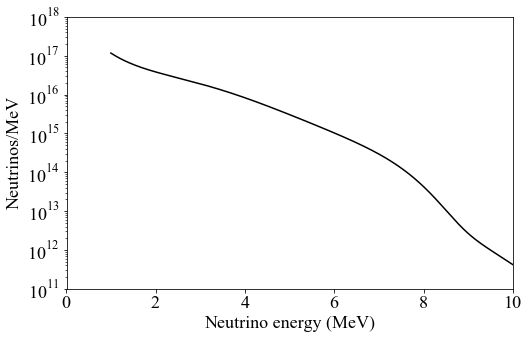

In [30]:


E_thr = np.linspace(0.,10.,200)
E_nu = np.linspace(1.,10.,500)
E_R = np.linspace(0.00000000001,10.,2000)
dE_nu = E_nu[2] - E_nu[1]

reactor = ReactorSpectra.ReactorSpectra()
reactor.reactorPower = 1.e6
reactor.ComputeFullSpectrum( E_nu )
print('Total antineutrinos emitted per second: {}'.format(sum(reactor.fullSpectrum)*dE_nu))
luminosity = np.sum(reactor.fullSpectrum)*dE_nu

detector = Detector.XenonDetector()
detector.distance = 0.01
detector.ComputeSolidAngleFraction()
print('Flux factor at detector: {}'.format(detector.fluxFactor))

print('Plotting reactor neutrino spectrum...')
plt.plot(E_nu,reactor.fullSpectrum,'-k')
plt.axis([0.01,10.,1.e11,1.e18])
plt.yscale('log')
plt.xlabel('Neutrino energy (MeV)')
plt.ylabel('Neutrinos/MeV')
plt.savefig('input_reactor_antineutrino_spectrum.png',dpi=600)

In [32]:
# Use luminosity, now multiply each by its MWe power and then scale by the 1/distance^2

db_reactors['Flux at Homestake'] = np.zeros(len(db_reactors['lat (-90 to 90)']))
db_reactors['Flux at LNGS'] = np.zeros(len(db_reactors['lat (-90 to 90)']))
db_reactors['Flux at SNOLAB'] = np.zeros(len(db_reactors['lat (-90 to 90)']))

for index,row in db_reactors.iterrows():
    db_reactors['Flux at Homestake'].loc[index] = \
        luminosity * row['Gross (MWe)'] / (4 * np.pi * (row['Dist to Homestake']*1.e5)**2 )
    db_reactors['Flux at LNGS'].loc[index] = \
        luminosity * row['Gross (MWe)'] / (4 * np.pi * (row['Dist to LNGS']*1.e5)**2 )
    db_reactors['Flux at SNOLAB'].loc[index] = \
        luminosity * row['Gross (MWe)'] / (4 * np.pi * (row['Dist to SNOLAB']*1.e5)**2 )
    





In [33]:
print(db_reactors[['Country','Dist to Homestake']])

                  Country  Dist to Homestake
0                     NaN                NaN
1                 ARMENIA        8185.837207
2                 ARMENIA        8185.837207
3               ARGENTINA        8864.483920
4               ARGENTINA        8570.328643
5               ARGENTINA        8864.022086
6                 BELGIUM        8208.631695
7                 BELGIUM        5558.293981
8                 BELGIUM        5650.688568
9                 BELGIUM        5558.293981
10                BELGIUM        5558.293981
11                BELGIUM        5650.688568
12                BELGIUM        5558.293981
13                BELGIUM        5650.688568
14               BULGARIA        7016.930804
15               BULGARIA        7016.930804
16               BULGARIA        7016.930804
17               BULGARIA        7016.930804
18               BULGARIA        7016.930804
19               BULGARIA        7016.930804
20                 BRAZIL        8722.087854
21        

In [37]:


flux_at_homestake = np.sum( db_reactors['Flux at Homestake'].loc[op_mask] )

flux_at_lngs = np.sum( db_reactors['Flux at LNGS'].loc[op_mask] )

flux_at_snolab = np.sum( db_reactors['Flux at SNOLAB'].loc[op_mask])

print('Flux at Homestake: {:2.2F}'.format(flux_at_homestake))
print('Flux at LNGS: {:2.2F}'.format(flux_at_lngs))
print('Flux at SNOLAB: {:2.2F}'.format(flux_at_snolab))

print('\n\n\n')

big_contributor_mask = (db_reactors['Flux at Homestake'] > 1.e3)&(op_mask)
print('Biggest contributors at Homestake:')
print(db_reactors[['Sitename','Location','Dist to Homestake','Flux at Homestake']].loc[big_contributor_mask])


big_contributor_mask = (db_reactors['Flux at LNGS'] > 2.e3)&(op_mask)
print('\n\n\n')
print('Biggest contributors at LNGS:')
print(db_reactors[['Country','Location','Dist to LNGS','Flux at LNGS']].loc[big_contributor_mask])

big_contributor_mask = (db_reactors['Flux at SNOLAB'] > 2.e3)&(op_mask)
print('\n\n\n')
print('Biggest contributors at SNOLAB:')
print(db_reactors[['Country','Location','Dist to SNOLAB','Flux at SNOLAB']].loc[big_contributor_mask])



Flux at Homestake: 44803.04
Flux at LNGS: 123255.49
Flux at SNOLAB: 272127.26




Biggest contributors at Homestake:
       Sitename           Location  Dist to Homestake  Flux at Homestake
466  MONTICELLO  Wright County, MN         787.222503        1018.481008
488      COOPER         Nemaha, NE         799.239120        1145.378267
563  WOLF CREEK        Hampden, KS         954.899253        1287.235202




Biggest contributors at LNGS:
         Country               Location  Dist to LNGS  Flux at LNGS
52   SWITZERLAND       Zurzach District    711.509779   2300.479276
81       GERMANY               Günzburg    717.357851   2385.599008
83       GERMANY               Günzburg    717.357851   2385.599008
85       GERMANY               Landshut    690.920369   2841.452159
158       FRANCE                  Isere    777.795171   2085.129736
159       FRANCE                  Isere    777.795171   2085.129736
403     SLOVENIA  Municipality of Krško    417.045766   3818.008279




Biggest c

In [12]:
def distance_calc( R, lat1, lon1, lat2, lon2 ):
    if lat1 < 0.:
        lat1 = -1.*lat1 + 90.
    else:
        lat1 = 90. - lat1
    if lat2 < 0.:
        lat2 = -1.*lat2 + 90.
    else:
        lat2 = 90. - lat2
    if lon1 < 0.:
        lon1 = (-1.*lon1) + 180.
    if lon2 < 0.:
        lon2 = (-1.*lon2) + 180.
        
    x1 = R * np.sin(lat1*np.pi/180.) * np.cos(lon1*np.pi/180.)
    y1 = R * np.sin(lat1*np.pi/180.) * np.sin(lon1*np.pi/180.)
    z1 = R * np.cos(lat1*np.pi/180.)
    
    x2 = R * np.sin(lat2*np.pi/180.) * np.cos(lon2*np.pi/180.)
    y2 = R * np.sin(lat2*np.pi/180.) * np.sin(lon2*np.pi/180.)
    z2 = R * np.cos(lat2*np.pi/180.)
    
    print('X1: {} Y1: {} Z1: {}'.format(x1,y1,z1))
    print('X2: {} Y2: {} Z2: {}'.format(x2,y2,z2))
    print('Dist: {}'.format(np.sqrt( (x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2 )))
    
    return np.sqrt( (x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2 )


In [13]:
india_mask = db_reactors['Country'] == 'INDIA'
print(db_reactors.loc[india_mask])




    Country      Sitename                     Location              Status  \
234   INDIA     TARAPUR-1         Palghar, Maharashtra         Operational   
235   INDIA    KAKRAPAR-2           Surat, Maharashtra         Operational   
236   INDIA   RAJASTHAN-3      Chittaurgarh, Rajasthan         Operational   
237   INDIA   RAJASTHAN-4      Chittaurgarh, Rajasthan         Operational   
238   INDIA       KAIGA-1    Uttara Kannada, Karnataka         Operational   
239   INDIA       KAIGA-2    Uttara Kannada, Karnataka         Operational   
240   INDIA       KAIGA-3    Uttara Kannada, Karnataka         Operational   
241   INDIA       KAIGA-4         Palghar, Maharashtra         Operational   
242   INDIA   RAJASTHAN-5      Chittaurgarh, Rajasthan         Operational   
243   INDIA     TARAPUR-2         Palghar, Maharashtra         Operational   
244   INDIA   RAJASTHAN-6      Chittaurgarh, Rajasthan         Operational   
245   INDIA   RAJASTHAN-7      Chittaurgarh, Rajasthan  Under Co

In [14]:
us_mask = db_reactors['Country'] == 'UNITED STATES'
print(db_reactors.loc[us_mask])

           Country           Sitename                    Location  \
442  UNITED STATES          ELK RIVER        Sherburne County, MN   
443  UNITED STATES          DRESDEN-1     Goose Lake Township, IL   
444  UNITED STATES         PATHFINDER        Brandon Township, SD   
445  UNITED STATES       HUMBOLDT BAY         Humboldt County, CA   
446  UNITED STATES               CVTR        Fairfield County, SC   
447  UNITED STATES     BIG ROCK POINT          Hayes Township, MI   
448  UNITED STATES            FERMI-1  Frenchtown Charter Twp, MI   
449  UNITED STATES     PEACH BOTTOM-1   Peach Bottom Township, PA   
450  UNITED STATES       SAN ONOFRE-1        San Diego County, CA   
451  UNITED STATES        HADDAM NECK        Middlesex County, CT   
452  UNITED STATES       OYSTER CREEK            Ocean County, NJ   
453  UNITED STATES  NINE MILE POINT-1                  Scriba, NY   
454  UNITED STATES          DRESDEN-2     Goose Lake Township, IL   
455  UNITED STATES              GI

In [15]:


print( distance_calc(R,44.35,-103.75,19.828981,72.661206) )

print(home_lat)
print(home_lon)

X1: 1082.8478810698223 Y1: -4425.234042279099 Z1: 4453.581158743688
X2: 1786.1185925649809 Y2: 5720.920730294037 Z2: 2161.131039753405
Dist: 10425.659399324059
10425.659399324059
44.35
-103.75


In [16]:
print( distance_calc(R,19.828981,72.661206,44.35,-103.75) )

X1: 1786.1185925649809 Y1: 5720.920730294037 Z1: 2161.131039753405
X2: 1082.8478810698223 Y2: -4425.234042279099 Z2: 4453.581158743688
Dist: 10425.659399324059
10425.659399324059


In [113]:
print(home_lat)
print(home_lon*(-1)+180)

44.35
283.75


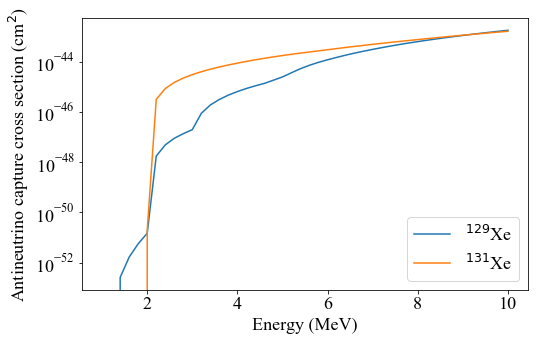

In [44]:
xe131_cs = np.genfromtxt('131Xe_I_antineutrino.dat',skip_header=3)
xe129_cs = np.genfromtxt('129Xe_I_antineutrino.dat',skip_header=3)

plt.plot(xe129_cs[:,0],xe129_cs[:,1],label='$^{129}$Xe')
plt.plot(xe131_cs[:,0],xe131_cs[:,1],label='$^{131}$Xe')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Antineutrino capture cross section (cm$^2$)')
plt.legend()